In [ ]:
# import libraries
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
from skimage.metrics import structural_similarity as ssim  # Import SSIM function
import rcParams
import json

/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-31 23:14:53,918] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


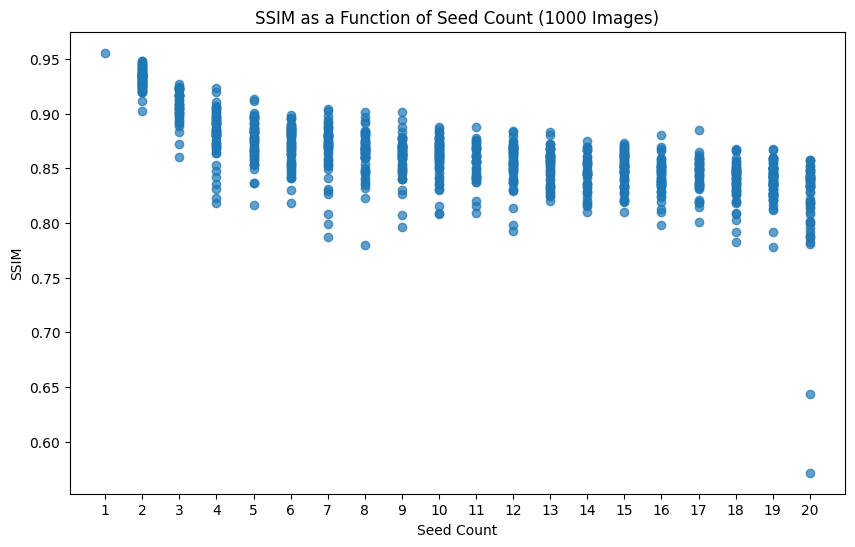

In [ ]:
"""Load the seeedcount file, images -> use trained model to generate latents -> decode latents to images-> compute SSIM with ground truth images -> plot SSIM vs seed count"""

# Paths and configuration
output_file = '/hpc/group/youlab/ks723/miniconda3/Lingchong/Sim_050924_seed_counts_testset_60000_70000.json'
datadir_i = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_input/intermediate/Tp3' 
datadir_o = "/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_output"          

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to(device)

# Load seed counts from JSON
with open(output_file, 'r') as f:
    seed_counts = json.load(f)

# Limit to 1000 images for this test
input_seed_keys = list(seed_counts.keys())[:1000]

# Function to decode latents to images
def decode_img(latents):
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        decoded_images = vae.decode(latents).sample
    decoded_images = (decoded_images / 2 + 0.5).clamp(0, 1)  # Scale to [0, 1]
    return decoded_images


# Load the model
# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):   
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)

# Load trained model
# Example usage
model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels 
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


NAME='Pixel_32x32x3to32x32x4_dilRESNET_30k_newpatterns_seedtointermediate__Model_v1113_Cluster_GPU_tfData-1731542355'
model.load_state_dict(torch.load(f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt'))
model.to(device)
model.eval()

# Parameters for image cropping and resizing
img_shape_i = 256
img_shape_o = 32
top_crop_i, bottom_crop_i, left_crop_i, right_crop_i = 30, 30, 31, 30
top_crop_o, bottom_crop_o, left_crop_o, right_crop_o = 0, 0, 3, 2

# Initialize lists
ssim_values = []
seed_count_list = []

# Function to load and process images
def load_image(image_path, img_shape, top_crop, bottom_crop, left_crop, right_crop):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    new_height = img_array.shape[0] - (top_crop + bottom_crop)
    new_width = img_array.shape[1] - (left_crop + right_crop)
    cropped_array = img_array[top_crop:top_crop + new_height, left_crop:left_crop + new_width]
    resized_array = cv2.resize(cropped_array, (img_shape, img_shape))
    return resized_array

# Process and calculate SSIM for each image
for input_seed_key in input_seed_keys:
    # Find corresponding seed input file by replacing 'Output' with 'Input'
    ground_truth_key = re.sub(r'^Input', 'Output', input_seed_key)

    # Paths to the ground truth (X) and seed input (y) images
    ground_truth_path = os.path.join(datadir_i, ground_truth_key)
    seed_input_path = os.path.join(datadir_o, input_seed_key)

    # Load and preprocess images
    X_img = load_image(ground_truth_path, img_shape_i, top_crop_i, bottom_crop_i, left_crop_i, right_crop_i)
    y_img = load_image(seed_input_path, img_shape_o, top_crop_o, bottom_crop_o, left_crop_o, right_crop_o)

    # Prepare tensors
    X_tensor = torch.Tensor(X_img).unsqueeze(0).unsqueeze(0).to(device) / 255.0  # Shape: [1, 1, 256, 256]
    y_tensor = torch.Tensor(y_img).unsqueeze(0).repeat(1, 3, 1, 1).to(device) / 255.0  # Shape: [1, 3, 32, 32]

    # Generate predictions
    with torch.no_grad():
        predicted_latents = model(y_tensor)
        predicted_image = decode_img(predicted_latents)

    # Resize predicted image to match ground truth dimensions
    predicted_image_resized = torch.nn.functional.interpolate(predicted_image, size=(img_shape_i, img_shape_i), mode='bilinear')

    # Convert tensors to numpy arrays
    X_np = X_tensor.squeeze().cpu().numpy()  # Shape: [256, 256]
    pred_np = predicted_image_resized.squeeze().cpu().numpy()  # Shape: [3, 256, 256]
    pred_np = np.transpose(pred_np, (1, 2, 0))  # Shape: [256, 256, 3]

    # Convert predicted image to grayscale
    pred_gray = np.dot(pred_np[..., :3], [0.2989, 0.5870, 0.1140])  # Shape: [256, 256]

    # Compute SSIM
    ssim_value = ssim(X_np, pred_gray, data_range=1.0)
    ssim_values.append(ssim_value)
    
    # Get seed count for the image
    seed_count_list.append(seed_counts[input_seed_key])

# Plot SSIM values as a function of seed count for these 1000 images
plt.figure(figsize=(10, 6))
# rcParams['font.family'] = 'Aptos'
plt.xticks(range(0, 21)) 
plt.scatter(seed_count_list, ssim_values, alpha=0.7)
plt.xlabel('Seed Count')
plt.ylabel('SSIM')
plt.title('SSIM as a Function of Seed Count (1000 Images)')
plt.show()


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_1561310/2369922244.py:245: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.001, wspace=0.001)
/tmp/ipykernel_1561310/2369922244.py:266: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Ground Truth Seed Count: 1
Ground Truth Seed Count: 4
Ground Truth Seed Count: 7
Ground Truth Seed Count: 10
Ground Truth Seed Count: 13
Ground Truth Seed Count: 16
Ground Truth Seed Count: 20


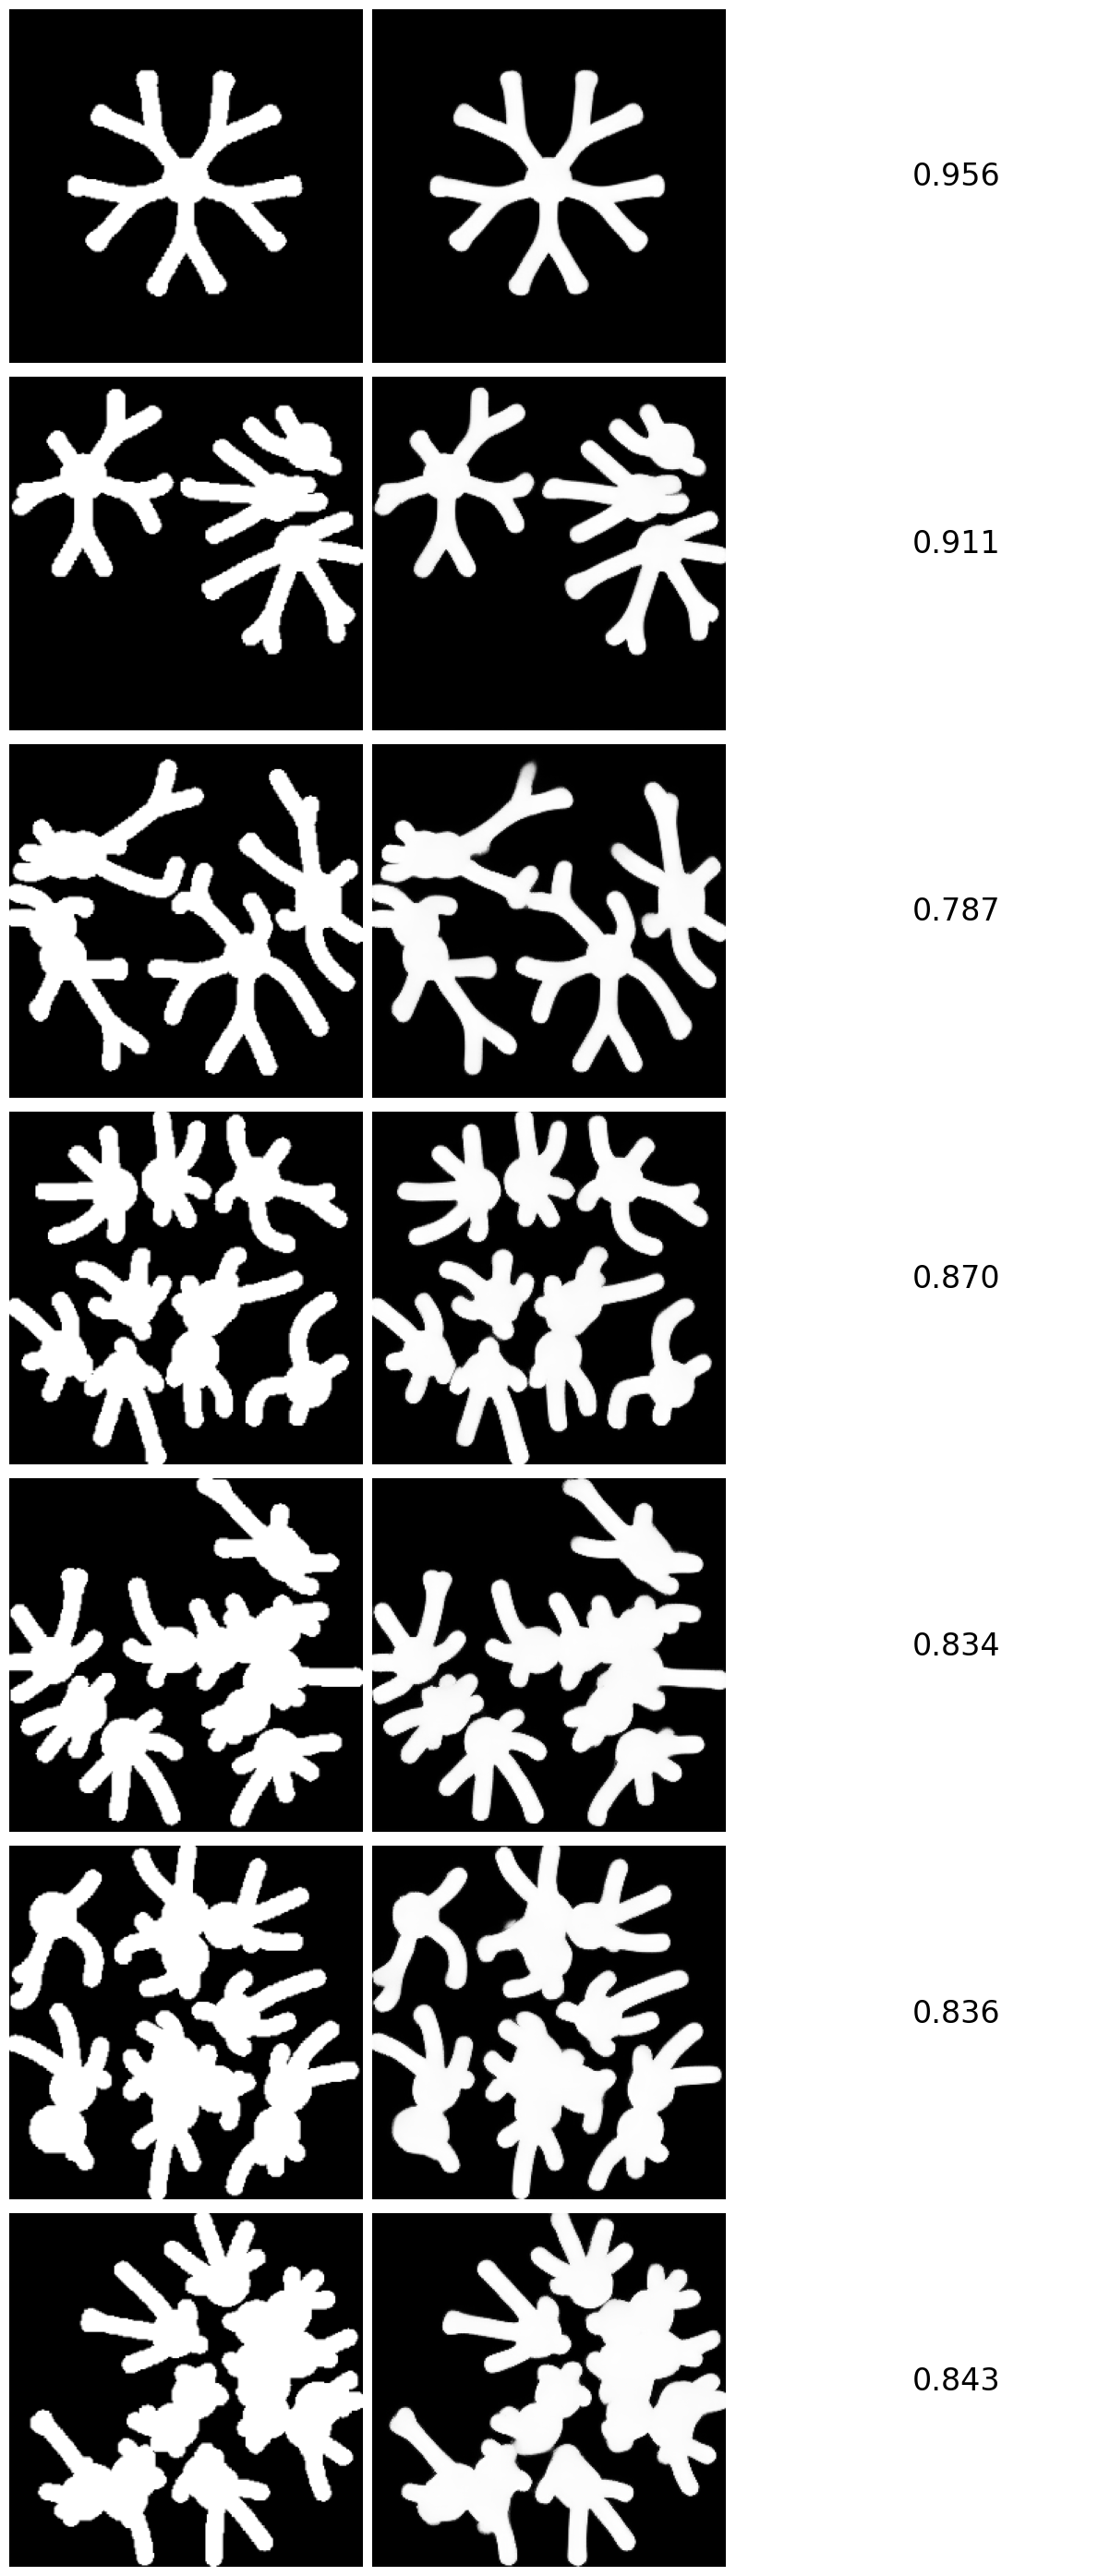

In [ ]:
"""Display the SSIM scores for the various image pairs, increasing in complexity from 1 seed to 20 seeds"""

# Paths and configuration
output_file = '/hpc/group/youlab/ks723/miniconda3/Lingchong/Sim_050924_seed_counts_testset_60000_70000.json'
datadir_i = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_input/intermediate/Tp3' 
datadir_o = "/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_output"          

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to(device)

# Load seed counts from JSON
with open(output_file, 'r') as f:
    seed_counts = json.load(f)

# Limit to 1000 images for this test
input_seed_keys = list(seed_counts.keys())[:1000]

# Function to decode latents to images
def decode_img(latents):
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        decoded_images = vae.decode(latents).sample
    decoded_images = (decoded_images / 2 + 0.5).clamp(0, 1)  # Scale to [0, 1]
    return decoded_images


# Load the model
# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):   
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)

# Load trained model
# Example usage
model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels 
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


# model_name = 'Pixel_32x32x3to32x32x4_RESNET_30k_newpatterns_seedtointermediate__Model_v1029_Cluster_GPU_tfData-1730233626'
model_name='Pixel_32x32x3to32x32x4_dilRESNET_30k_newpatterns_seedtointermediate__Model_v1113_Cluster_GPU_tfData-1731542355'
model.load_state_dict(torch.load(f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{model_name}.pt'))
model.to(device)
model.eval()

# Parameters for image cropping and resizing
img_shape_i = 256
img_shape_o = 32
top_crop_i, bottom_crop_i, left_crop_i, right_crop_i = 30, 30, 31, 30
top_crop_o, bottom_crop_o, left_crop_o, right_crop_o = 0, 0, 3, 2

# Initialize lists
ssim_values = []
seed_count_list = []
ground_truth_images = []
predicted_images_list = []

# Function to load and process images
def load_image(image_path, img_shape, top_crop, bottom_crop, left_crop, right_crop):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    new_height = img_array.shape[0] - (top_crop + bottom_crop)
    new_width = img_array.shape[1] - (left_crop + right_crop)
    cropped_array = img_array[top_crop:top_crop + new_height, left_crop:left_crop + new_width]
    resized_array = cv2.resize(cropped_array, (img_shape, img_shape))
    return resized_array

# Process and calculate SSIM for each image
for input_seed_key in input_seed_keys:
    # Find corresponding seed input file by replacing 'Input' with 'Output'
    ground_truth_key = re.sub(r'^Input', 'Output', input_seed_key)

    # Paths to the ground truth (X) and seed input (y) images
    ground_truth_path = os.path.join(datadir_i, ground_truth_key)
    seed_input_path = os.path.join(datadir_o, input_seed_key)

    # Load and preprocess images
    X_img = load_image(ground_truth_path, img_shape_i, top_crop_i, bottom_crop_i, left_crop_i, right_crop_i)
    y_img = load_image(seed_input_path, img_shape_o, top_crop_o, bottom_crop_o, left_crop_o, right_crop_o)

    # Prepare tensors
    X_tensor = torch.Tensor(X_img).unsqueeze(0).unsqueeze(0).to(device) / 255.0  # Shape: [1, 1, 256, 256]
    y_tensor = torch.Tensor(y_img).unsqueeze(0).repeat(1, 3, 1, 1).to(device) / 255.0  # Shape: [1, 3, 32, 32]

    # Generate predictions
    with torch.no_grad():
        predicted_latents = model(y_tensor)
        predicted_image = decode_img(predicted_latents)

    # Resize predicted image to match ground truth dimensions
    predicted_image_resized = torch.nn.functional.interpolate(predicted_image, size=(img_shape_i, img_shape_i), mode='bilinear')

    # Convert tensors to numpy arrays
    X_np = X_tensor.squeeze().cpu().numpy()  # Shape: [256, 256]
    pred_np = predicted_image_resized.squeeze().cpu().numpy()  # Shape: [3, 256, 256]
    pred_np = np.transpose(pred_np, (1, 2, 0))  # Shape: [256, 256, 3]

    # Convert predicted image to grayscale
    pred_gray = np.dot(pred_np[..., :3], [0.2989, 0.5870, 0.1140])  # Shape: [256, 256]

    # Compute SSIM
    ssim_value = ssim(X_np, pred_gray, data_range=1.0)
    ssim_values.append(ssim_value)

    # Get seed count for the image
    seed_count = seed_counts[input_seed_key]
    seed_count_list.append(seed_count)

    # Collect ground truth and predicted images for later visualization
    ground_truth_images.append(X_np)
    predicted_images_list.append(pred_gray)

# Now select 5 images with increasing seed counts
# Get unique seed counts and sort them
unique_seed_counts = sorted(set(seed_count_list))
num_samples = 7

# Select 5 seed counts evenly spaced across the range
selected_seed_counts_values = np.linspace(unique_seed_counts[0], unique_seed_counts[-1], num_samples, dtype=int)
selected_indices = []

# For each selected seed count, find an image with that seed count or the closest one
for sc in selected_seed_counts_values:
    # Find indices of images with the exact seed count
    indices_with_sc = [i for i, count in enumerate(seed_count_list) if count == sc]
    if indices_with_sc:
        selected_indices.append(indices_with_sc[0])
    else:
        # If no exact match, find the closest seed count
        closest_index = min(range(len(seed_count_list)), key=lambda i: abs(seed_count_list[i] - sc))
        selected_indices.append(closest_index)

# Now collect the selected images and SSIM values
selected_ground_truth_images = [ground_truth_images[i] for i in selected_indices]
selected_predicted_images = [predicted_images_list[i] for i in selected_indices]
selected_ssim_values = [ssim_values[i] for i in selected_indices]
selected_seed_counts = [seed_count_list[i] for i in selected_indices]

# Function to display images with SSIM values
def display_images_with_ssim_map(ground_truth_images, predicted_images, ssim_values, seed_counts):
    num_samples = len(ground_truth_images)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4),layout='constrained')
    fig.subplots_adjust(hspace=0.001, wspace=0.001)

    for i in range(num_samples):
        gt_image = ground_truth_images[i]
        pred_image = predicted_images[i]
        ssim_value = ssim_values[i]
        seed_count = seed_counts[i]

        axes[i, 0].imshow(gt_image, cmap='gray')
        axes[i, 0].axis('off')
        print(  f'Ground Truth Seed Count: {seed_count}')
        # axes[i, 0].set_title(f'Ground Truth\nSeed Count: {seed_count}')

        axes[i, 1].imshow(pred_image, cmap='gray')
        axes[i, 1].axis('off')
        # axes[i, 1].set_title('Predicted Image')

        axes[i, 2].text(0.5, 0.5, f'{ssim_value:.3f}',fontsize=24) #f'SSIM: {ssim_value:.3f}', ha='center', va='center', fontsize=24
        axes[i, 2].axis('off')
        # axes[i, 2].set_title('SSIM Value')

    plt.tight_layout()
    plt.show()

# Display the selected images and SSIM values
display_images_with_ssim_map(selected_ground_truth_images, selected_predicted_images, selected_ssim_values, selected_seed_counts)
